# Task 1.1a - Exploratory data of single variables

Consider the following code to produce summaries of the `Rooms`, `Price`, `Method`, `Distance` and `Landsize` variables.
Data was only dropped if a string did not represent a number (but should have). We furthermore define helper functions
`category_counts` and `last_less_index`.

In [1]:
using Pkg
Pkg.activate(".")

using Plots, DataFrames, CSV


function last_less_index(item, categories)
    for (i, cat) in enumerate(categories)
        item < cat && return i - 1
    end
    return length(categories)
end


"""
Count the number of items in the iterator iter belonging to each category. The
items of iter must be totally ordered and of the same type of those in
categories.
"""
function category_counts(iter, categories)
    results = zeros(Int, length(categories))
    for item in iter
        results[last_less_index(item, categories)] += 1
    end
    return results
end


function category_counts(iter)
    categories = Dict{String, Int}()
    for item in iter
        categories[item] = haskey(categories, item) ? categories[item] + 1 : 1
    end
    results = collect(categories)
    return (first.(results), last.(results))
end


data = DataFrame(CSV.File("data/Melbourne_housing_FULL.csv"; missingstring = "NA"))


room() = bar(
    ["1", "2", "3", "4", "5", "6+"],
    category_counts(data.Rooms, 1:6);
    title = "Room Distribution",
    label = false)

prices() = histogram(
    [parse(Int, x) for x in data.Price if length(x) > 0];
    title = "Prices Distribution",
    legend = false)

method() = bar(category_counts(data.Method)...;
    title = "Method",
    label = false)

distance() = histogram(
    [parse(Float32, x) for x in data.Distance if isdigit(first(x))];
    title = "Distance",
    xlabel = "Distance from CBD (km)",
    label = false)

const superscript_2 = Char(0x00B2)

function landsize()
    land_data = [parse(Int, x) for x in data.Landsize if length(x) > 0]
    buckets = collect(0:200:1000)
    labels = Vector{String}(undef, length(buckets))
    for i in 2:length(buckets)
        labels[i - 1] = "$(buckets[i - 1])-$(buckets[i] - 1)"
    end
    labels[end] = "$(buckets[end])+"
    return bar(
        labels,
        category_counts(land_data, buckets);
        title = "Land Sizes",
        label = false,
        xlabel = "Land size (m$superscript_2)")
end

  Activating project at `~/Documents/MATH2504/Mitchell-Holt-2504-2023-PROJECT3`
[ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]


landsize (generic function with 1 method)

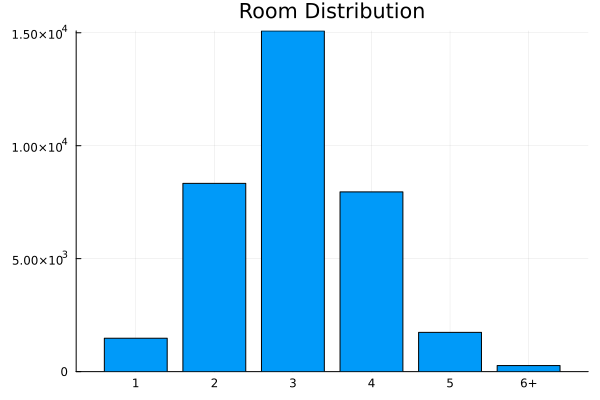

In [2]:
room()

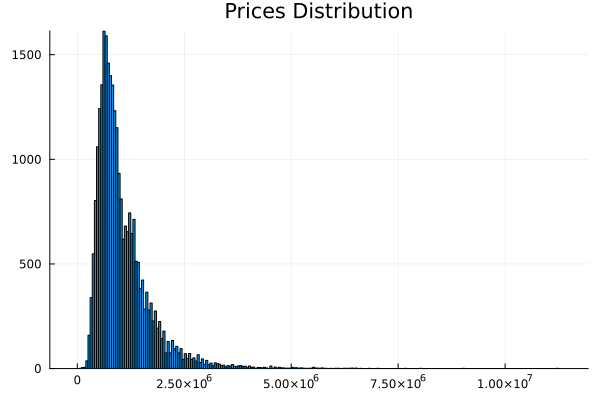

In [3]:
prices()

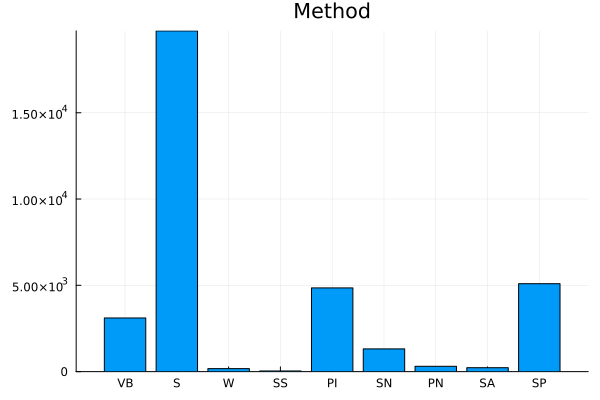

In [4]:
method()

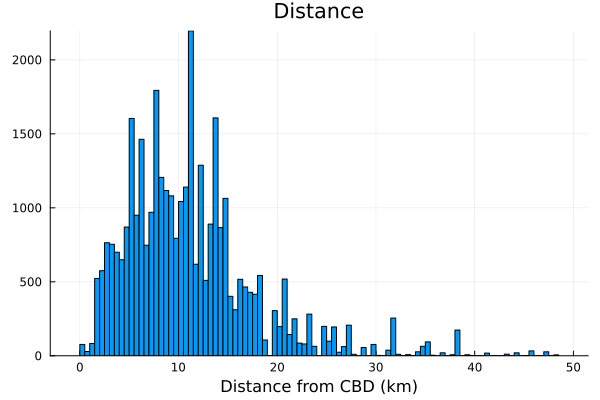

In [5]:
distance()

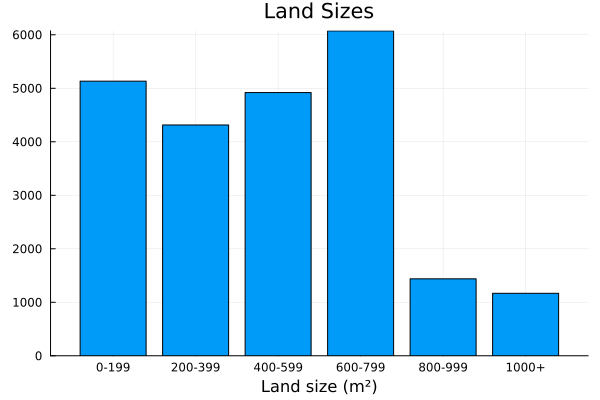

In [6]:
landsize()

# Task 1.2a - Exploratory data analysis comparing variables

In [7]:
using StatsBase

# drop bad data and parse 
relevant_data = select(data, [:Distance, :Rooms, :Price])
filter!(:Distance => s -> isdigit(first(s)), relevant_data)
filter!(:Price => s -> length(s) > 0, relevant_data)
transform!(relevant_data, :Distance => ByRow(s -> parse(Float32, s)) => :Distance)
transform!(relevant_data, :Price => ByRow(s -> parse(Int, s)) => :Price)
transform!(relevant_data, :Rooms => ByRow(s -> s < 6 ? string(s) : "6+") => :Rooms)
sort!(relevant_data)

# Distance summary - plot price as a function of time
distance_price() = plot(
    relevant_data.Distance,
    relevant_data.Price;
    title = "Price vs Distance",
    label = false,
    xlabel = "Distance from CBD (km)",
    ylabel = "Price")

# Room summary - q1, median, q3 price (as series in a bar) for each room size.
# We need to transform the data into a matrix where rows are different room
#   categories, cols are q1, median, q3 resp.
function room_price()
    room_price_data = combine(groupby(relevant_data, :Rooms),
        :Price => x -> tuple(nquantile(x, 4)[2:4]))
    price_data = map(reverse ∘ first, room_price_data.Price_function)

    bar_array = Array{Float64}(undef, nrow(room_price_data), 3)
    for i in 1:nrow(room_price_data)
        bar_array[i,:] = price_data[i]
    end
    return bar(room_price_data.Rooms, bar_array;
        title = "Price vs Rooms summary",
        xlabel = "Number of rooms",
        ylabel = "Price",
        label = ["Q3" "Median" "Q1"])
end

function room_distance_price()
    room_data = filter(:Rooms => ==("1"), relevant_data)
    plt = plot(room_data.Distance, room_data.Price;
        title = "Price vs Distance Summary",
        xlabel = "Distance from CBD (km)",
        ylabel = "price",
        label = "1 room")
    for room_size in ["2", "3", "4", "5", "6+"]
        room_data = filter(:Rooms => ==(room_size), relevant_data)
        plot!(room_data.Distance, room_data.Price;
            label = "$room_size rooms")
    end
    return plt
end

room_distance_price (generic function with 1 method)

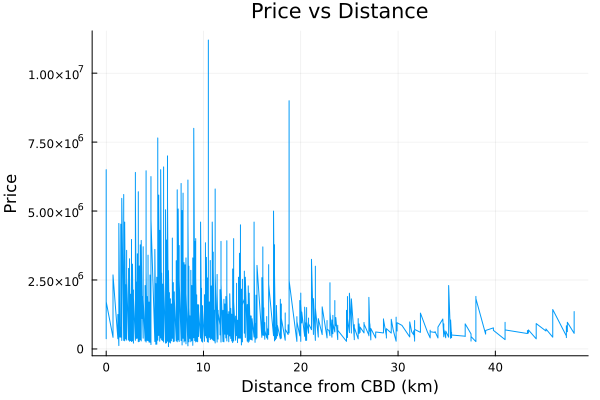

In [8]:
distance_price()

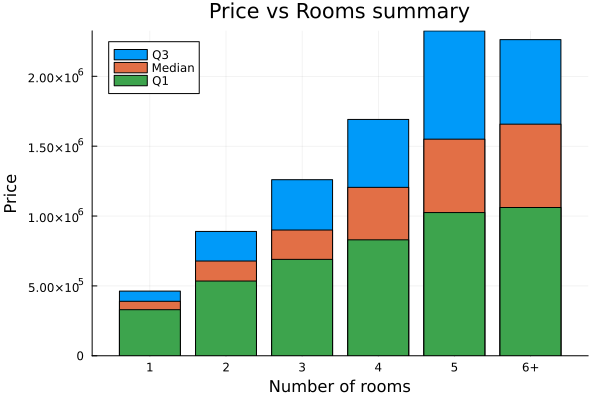

In [9]:
room_price()

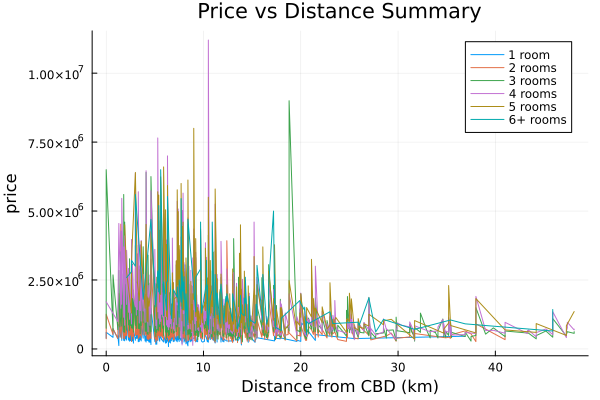

In [10]:
room_distance_price()

There is a clear correlation between the number of rooms and the price, and for each fixed number of rooms
we observe a general decrease in price as distance from the CBD increases.

# Task 1.3a - Exploratory data analysis over time

In [11]:
struct Date
    month :: Int
    year :: Int
end

# Helper functions for date
function Base.isless(d1 :: Date, d2 :: Date)
    d1.year == d2.year ? d1.month < d2.month : d1.year < d2.year
end

# Assume the string is formatted dd/mm/yyyy
function parseDate(str)
    tokens = split(str, "/")
    return Date(
        parse(Int, tokens[2]),
        parse(Int, tokens[3]))
end

to_string(date :: Date) = "$(date.month)/$(date.year)"

# Do data stuff idk
relevant_data = select(data, [:Date, :Price, :Type])
filter!(:Price => s -> length(s) > 0, relevant_data)
transform!(relevant_data, :Price => ByRow(s -> parse(Int, s)) => :Price)
transform!(relevant_data, :Date => ByRow(parseDate) => :Date)

house_data = filter(:Type => ==("h"), relevant_data)

all_month_groups = groupby(relevant_data, :Date)
house_month_groups = groupby(house_data, :Date)

# Properties sold over time, with series for by volume and by value
function properties_time_volume(data_groups, group_name)
    volume = combine(data_groups, :Price => length)
    return plot(0:(nrow(volume) - 1), volume.Price_length;
        label = false,
        xlabel = "Number of months after $(to_string(first(volume.Date)))",
        ylabel = "Number of properties sold",
        title = "Volume of sales over time ($group_name)")
end

function properties_time_value(data_groups, group_name)
    value = combine(data_groups, :Price => sum)
    return plot(0:(nrow(value) - 1), value.Price_sum;
        label = false,
        xlabel = "Number of months after $(to_string(first(value.Date)))",
        ylabel = "Total value of properties sold",
        title = "Value of sales over time ($group_name)")
end

properties_time_value (generic function with 1 method)

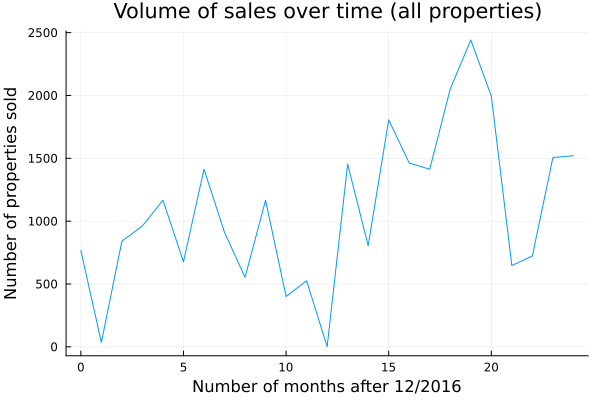

In [12]:
properties_time_volume(all_month_groups, "all properties")

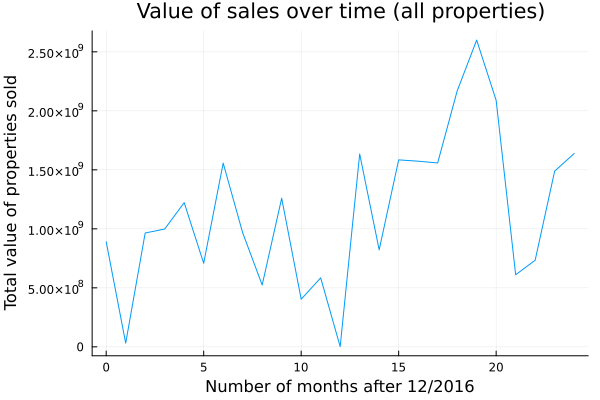

In [13]:
properties_time_value(all_month_groups, "all properties")

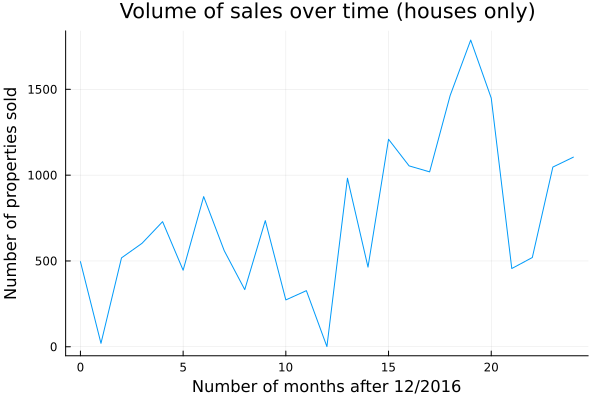

In [14]:
properties_time_volume(house_month_groups, "houses only")

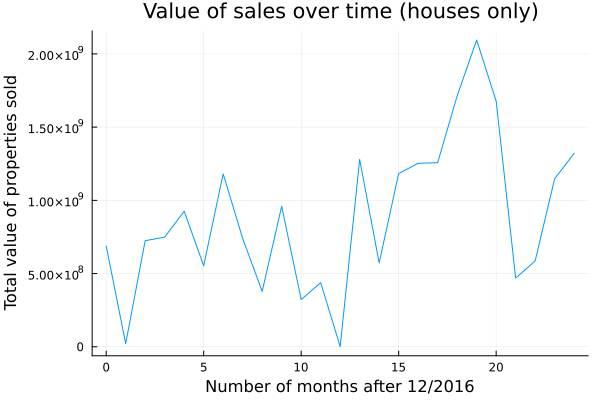

In [15]:
properties_time_value(house_month_groups, "houses only")